# Home Credit Default Risk

1. Introdução | Overview
2. Descrição dos dados | Data Description
3. Carregando os dados | Load data
4. Análise Exploratória | Data Exploration 

    4.1 Empréstimos - dados de treinamento | Loan - train data set
        4.1.1 Distribuição da variavel Target | Target Distribuction 
        4.1.2 Analise dos empréstimos | Loan analysis
    4.2 Analise do histórico de crédito | Todo 
        4.2.1 Crédito anteriores fornecidos por outras instituições | Todo 
        4.2.2 Crédito anteriores na Credit Bureau | Todo 
        4.2.3 Histórico mensal de emprestimo na Home Credit | Todo 
        4.2.4 Histórico mensal no cartão de crédito na Home Credit | Todo 
        4.2.5 Solicitações de crédito anteriores na Home Credit | Todo 
        4.2.6 Histórico de amortização na Home Credit | Todo 
    4.3 Todo
5. Correlação | Correlation
6. Feature Selection with Random Forest
7. ...

## 1. Introdução | Overview

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

[Home Credit Group](http://www.homecredit.net/) strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.


## 2. Descrição dos Dados | Data Description


* application_{train|test}.csv

    * This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    * Static data for all applications. One row represents one loan in our data sample.

* bureau.csv

    * All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    * For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

* bureau_balance.csv

    * Monthly balances of previous credits in Credit Bureau.
    * This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

* POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.
installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
HomeCredit_columns_description.csv

This file contains descriptions for the columns in the various data files.

![teste](home_credit.png)

In [101]:
import time
import pandas as pd
import numpy as np

# DataViz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

%matplotlib inline
plt.style.use('ggplot')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### 3. Carregando os dados | Load Data

In [4]:
def load_data(data_src):
    
    start_time = time.time()
    
    train = pd.read_csv('{}application_train.csv'.format(data_src))
    test = pd.read_csv('{}application_test.csv'.format(data_src))
    print('Train and test tables loaded.')
    
    bureau = pd.read_csv('{}bureau.csv'.format(data_src))
    bureau_bal = pd.read_csv('{}bureau_balance.csv'.format(data_src))
    print('Bureau data loaded.')
    
    prev = pd.read_csv('{}previous_application.csv'.format(data_src))
    print('Previous applications data loaded.')
    
    cred_card_bal = pd.read_csv('{}credit_card_balance.csv'.format(data_src))
    print('Credit card balance loaded.')
    
    pos_cash_bal = pd.read_csv('{}POS_CASH_balance.csv'.format(data_src))
    print('POS cash balance loaded.')
    
    ins = pd.read_csv('{}installments_payments.csv'.format(data_src))
    print('Installments data loaded.')
    
    # error if using engine c - 'utf-8' codec can't decode byte 0x85
    data_description = pd.read_csv('{}HomeCredit_columns_description.csv'.format(data_src), engine='python')
    
    print('Time it took to load all the data: {:.4f}s\n'.format(time.time() - start_time))
    
    return train, test, bureau, bureau_bal, prev, cred_card_bal, pos_cash_bal, ins, data_description

train, test, bureau, bureau_bal, prev, cred_card_bal, pos_cash_bal, ins, data_description = load_data('data/all/')

Train and test tables loaded.
Bureau data loaded.
Previous applications data loaded.
Credit card balance loaded.
POS cash balance loaded.
Installments data loaded.
Time it took to load all the data: 57.3358s



**Table Description**

In [237]:
# Data Description 

train_desc =  data_description[data_description['Table'] == 'application_{train|test}.csv']
train_desc[['Row', 'Description', 'Special']].head(10)

,Row,Description,Special
0,SK_ID_CURR,ID of loan in our sample,NaN
1,TARGET,Target variable (1 - client with payment diffi...,NaN
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,CODE_GENDER,Gender of the client,NaN
4,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,CNT_CHILDREN,Number of children the client has,NaN
7,AMT_INCOME_TOTAL,Income of the client,NaN
8,AMT_CREDIT,Credit amount of the loan,NaN
9,AMT_ANNUITY,Loan annuity,NaN


In [250]:
# Column detail
def print_col_description(col_name):
    return(train_desc[train_desc['Row'] == col_name]['Description'].values)

print('NAME_CONTRACT_TYPE: {}'.format(print_col_description('NAME_CONTRACT_TYPE')))
print('TARGET: {}'.format(print_col_description('TARGET')))

NAME_CONTRACT_TYPE: ['Identification if loan is cash or revolving']
TARGET: [ 'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)']


## 4. Analise Exploratória | Data Exploration

### 4.1 Empréstimos - dados de treino

#### 4.1.1 Distribuição da variável Target | Target Distribuction 

8.7818% dos contratos não são pagos. 



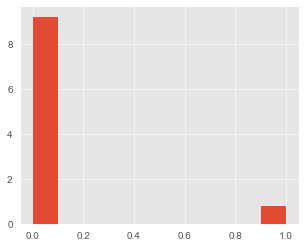

In [255]:
target_dist = train['TARGET'].value_counts()
proporcao = target_dist.iloc[1]/target_dist.iloc[0]*100

print('{:.4f}% dos contratos não são pagos. \n'.format(proporcao))

plt.figure(figsize=(5,4))
plt.title = 'Distribuição normalizada - TARGET' # Todo: Pq não está aparecendo?
plt.hist(x=train['TARGET'], normed=True)
plt.show()

#### 4.1.2 Analise dos empréstimos | Loan analysis

In [67]:
temp = train["ORGANIZATION_TYPE"].value_counts()
temp.iplot(kind='bar', xTitle = 'Organization Name', yTitle = "Count", 
           title = 'Types of Organizations who applied for loan ', color = 'red')

In [267]:
# Criando o data set por Tipo de Organização

def create_score_organization_type():

    temp = pd.DataFrame(train.groupby(['ORGANIZATION_TYPE', 'TARGET']).size())
    temp.reset_index(inplace=True)
    temp.rename(columns = {0:'Qtde'}, inplace = True)

    score_organization = pd.pivot_table(temp,index=['ORGANIZATION_TYPE'], columns=['TARGET'], 
                                        values=['Qtde'], aggfunc=[np.sum], fill_value=0, margins=True)
    score_organization.reset_index(inplace=True)
    score_organization.rename(columns={ 0:'good_credit', 1:'bad_credit'}, inplace=True)
    score_organization = score_organization.sort_values(by=[('sum', 'Qtde', 'All')], ascending=False)[1:len(score_organization)]

    return score_organization

score_organization = create_score_organization_type()


In [268]:
trace1 = go.Bar(
    x = score_organization['ORGANIZATION_TYPE'],
    y = score_organization[('sum', 'Qtde', 'good_credit')],
    name = 'Good'
)
trace2 = go.Bar(
    x = score_organization['ORGANIZATION_TYPE'],
    y = score_organization[('sum', 'Qtde', 'bad_credit')],
    name = 'Bad'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack', 
    title='Contratos por Tipo de Organização'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [251]:
temp = train["OCCUPATION_TYPE"].value_counts()
temp.iplot(kind='bar', xTitle = 'Occupation', yTitle = "Count", title = 'Occupation of Applicant\'s who applied for loan', color = 'green')